**Capstone Project**

**Introduction: Business Problem**

In this project will try to find an optimal location for a restaurant, the cuisine and any special offerings. This report will be targeted to stakeholders interested in opening a restaurant in Toronto.

We are looking for the neighbourhood with the highest density of restaurants/cafes because this is where the customers are. The goal is then to identify a profitable niche for a given neighbourhood. The cuisine and offering should be similar to existing restaurants in that area so the product is selected for, with a point of differentiation so it stands out from the other restuarants/cafes.

**Data**

Based on the busines problem defined above the data to collect is:

number of restaurants and cafes in each neighbourhood

-the offering of each restaurant

-cuisine

-price level

-Outdoor Seating

-Payments accepted

-Drinks

The following data sources will be used:

-number of restaurants in every neighbourhood using Foursquare API

-features of each restaurant in target neighbourhood using Foursquare API

**Neighbourhood Candidates**

The candidate neighbourhoods are the neighbourhoods in the boroughs that have Toronto in their name. The steps are:

Generate the list of neighbourhoods and their associated postcode
Load postcode to geo-location data
Use the neighbourhood postcodes to determine the geo-location
Rank the number of food venues within 200m for each neighbourhood using the Foursquare API

**Data cleaning**

If Borough is not assigned ignore the row
If Borough is assigned and Neighbourhood is not assigned, then Neighbourhood is given the same value as Borough
If a postcode is on multiple rows, the Neighourhoods are combined together separated by commas

In [1]:
# get postcode page html
import requests
r = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

In [2]:
# build list of postcodes to import into pandas

from bs4 import BeautifulSoup
import pandas as pd

soup = BeautifulSoup(r.text, 'lxml')
table = soup.find_all('table')[0]
postcode_data_raw = {}
for row in table.find_all('tr'):
    columns = row.find_all('td')
    if columns:
        col0 = columns[0].get_text()
        col1 = columns[1].get_text()
        col2 = columns[2].get_text()[:-1]
        if col1 == "Not assigned":
            continue
        if col2 == "Not assigned":
            col2 = col1
        if col0 in postcode_data_raw.keys():
            postcode_data_raw[col0][1].append(col2)
        else:
            postcode_data_raw[col0] = (col1, [col2])

# transform to list sorted by postcode
postcode_data = []
for key, values in sorted(postcode_data_raw.items()):
    postcode_data.append([key, values[0], ", ".join(values[1])])

# build data frame
df_postcodes = pd.DataFrame(postcode_data, columns=['PostalCode', 'Borough', 'Neighbourhood'])

In [3]:
import pandas as pd

csv_url = "https://cocl.us/Geospatial_data"
df_geo_coords = pd.read_csv(csv_url)
df_geo_coords.rename(index=str, columns={"Postal Code":"PostalCode"}, inplace=True)

In [4]:
# merge df_postcodes and df_geo_coords
df_neighbourhoods = df_postcodes.merge(df_geo_coords, on="PostalCode")
# filter out Toronto boroughs
df_toronto = df_neighbourhoods[df_neighbourhoods['Borough'].str.contains('Toronto')].reset_index(drop=True)

In [5]:
# make a map of selected neighbourhoods
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

central_toronto_lat = 43.728020
central_toronto_long = -79.388790

# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[central_toronto_lat, central_toronto_long], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

In [6]:
# define foursquare credentials and version
CLIENT_ID = 'SUVUCZAL2D45JGPBV2RHZI0RMLRAHYMLO3PTM2MRDN223RXL' 
CLIENT_SECRET = 'P0GV15CSOEMPC2I0U32JY22J5QZH0K1AAB4LWKG0V3JWYELB' 
VERSION = '20180605' 
RADIUS = 200

In [7]:
# define supporting functions using the venues search API
import requests
import json # library to handle JSON files

def get_full_data_from_food_venues_near_location(lat, lon, limit=100):
    category = "4d4b7105d754a06374d81259"
    intent = "browse"
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lon, 
    RADIUS, 
    limit,
    intent,
    category
    )
    raw_results = requests.get(url).json()
    return raw_results['response']['venues']

def get_food_venues_near_location(lat, lon):
    results = get_full_data_from_food_venues_near_location(lat, lon)
    return [ (item['name'], item['id']) for item in results ]

def get_number_of_food_venues_near_location(lat, lon):
    return len(get_food_venues_near_location(lat, lon))
def get_neighbourhood_venue_counts(names, lats, lons):
    out = []
    for name, lat, lon in zip(names, lats, lons):
        num_food_venues = get_number_of_food_venues_near_location(lat, lon)
        out.append([name, num_food_venues])
    return out
def get_categories_of_food_venues_in_neighbourhood(neighbourhood):
    neighbourhood_lat = float(df_toronto[df_toronto['Neighbourhood'] == neighbourhood]['Latitude'])
    neighbourhood_lon = float(df_toronto[df_toronto['Neighbourhood'] == neighbourhood]['Longitude'])
    venues = get_full_data_from_food_venues_near_location(neighbourhood_lat, neighbourhood_lon)
    return [ item['categories'][0]['name'] for item in venues ]

def get_ids_of_food_venues_with_category(neighbourhood, category):
    neighbourhood_lat = float(df_toronto[df_toronto['Neighbourhood'] == neighbourhood]['Latitude'])
    neighbourhood_lon = float(df_toronto[df_toronto['Neighbourhood'] == neighbourhood]['Longitude'])
    venues = get_full_data_from_food_venues_near_location(neighbourhood_lat, neighbourhood_lon)
    return [ item['id'] for item in venues if item['categories'][0]['name'] == category]

def get_neighbourhood_food_venue_ids(neighbourhood):
    neighbourhood_lat = float(df_toronto[df_toronto['Neighbourhood'] == neighbourhood]['Latitude'])
    neighbourhood_lon = float(df_toronto[df_toronto['Neighbourhood'] == neighbourhood]['Longitude'])
    venues = get_food_venues_near_location(neighbourhood_lat, neighbourhood_lon)
    return [id for name, id in venues]

In [8]:
# get the number of food venues in each neighbourhood

neighbourhood_venues_count = get_neighbourhood_venue_counts(names=df_toronto['Neighbourhood'],
                                                            lats=df_toronto['Latitude'],
                                                            lons=df_toronto['Longitude']
                                                           )

df_venue_count = pd.DataFrame(neighbourhood_venues_count, columns=['Neighbourhood', "Food venues count"])
df_venue_count.sort_values(by=["Food venues count"], inplace=True, ascending=False)
df_venue_count.head()

,Neighbourhood,Food venues count
21,"Commerce Court, Victoria Hotel",50
17,Central Bay Street,48
29,"First Canadian Place, Underground city",47
26,"Chinatown, Grange Park, Kensington Market",45
20,"Design Exchange, Toronto Dominion Centre",43


**Categories of food venues in neighbourhood**

In [9]:
# get the categories for the food venues in the neighbourhood
NEIGHBOURHOOD = 'Commerce Court, Victoria Hotel'
df_categories = pd.DataFrame(data = get_categories_of_food_venues_in_neighbourhood(NEIGHBOURHOOD), columns = ['category'])
df_categories['category'].value_counts()[:5]

Coffee Shop             11
Restaurant               5
Deli / Bodega            4
Fast Food Restaurant     4
Japanese Restaurant      3
Name: category, dtype: int64

**Attributes**

In [10]:
# define support functions that use the venues API - restricted use in sandbox account

def get_attribute(json_blob, attr_name):
    for item in json_blob:
        if item['name'] == attr_name:
            return int(item['count'])
    # if get here attribute is not present
    return 0

def get_value_features_column_names():
    columns = []
    columns.append("Name")
    columns.append("Price")
    for a_label in ["Outdoor Seating", "Wi-Fi"]:
        columns.append(a_label)
    return columns

def get_venue_features(venue_id):
    url = "https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}".format(
        venue_id,
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION
    )
    raw_results = requests.get(url).json()
    out = []
    # name
    out.append(raw_results['response']['venue']['name'])
    # price
    out.append(int(raw_results['response']['venue']['price']['tier']))
    # attributes
    attributes = raw_results['response']['venue']['attributes']['groups']
    for a_label in ["Outdoor Seating", "Wi-Fi"]:
        columns.append(a_label)
        out.append(get_attribute(attributes, a_label))
    return out

In [11]:
CATEGORY = "Coffee Shop"

features = []
for venue_id in get_ids_of_food_venues_with_category(NEIGHBOURHOOD, CATEGORY):
   features.append(get_venue_features(venue_id))
columns = get_value_features_column_names()
           
df_features = pd.DataFrame(data=features, columns=columns)
df_features

,Name,Price,Outdoor Seating,Wi-Fi
0,Starbucks,2,1,1
1,Starbucks,1,1,1
2,Pilot Coffee Roasters,1,0,0
3,Starbucks,1,1,0
4,Starbucks,1,1,1
5,Tim Hortons,1,1,1
6,Starbucks,1,1,1
7,Dineen @CommerceCourt,1,0,0
8,Tim Hortons,1,0,0
9,Second Cup,1,0,0


In [12]:
# support function to draw histograms
def draw_histogram(column, bins, xlabel, title):
    ax = df_features.hist(column=column, bins=bins, grid=False, figsize=(7,5), color='#86bf91', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Set title
        x.set_title(title)

        # Set x-axis label
        x.set_xlabel(xlabel, labelpad=20, weight='bold', size=12)

        # Remove y axis
        x.set_ylabel("")

In [13]:
# Get the most common price category and plot the histogram
common_price = df_features.groupby("Price").count()['Name'].idxmax()
print("The most common price category is {}".format(common_price))
price_bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
draw_histogram("Price", price_bins, "Price", "Price levels for category {} in {}".format(CATEGORY, NEIGHBOURHOOD))

The most common price category is 1


The most common outdoor seating category is 1


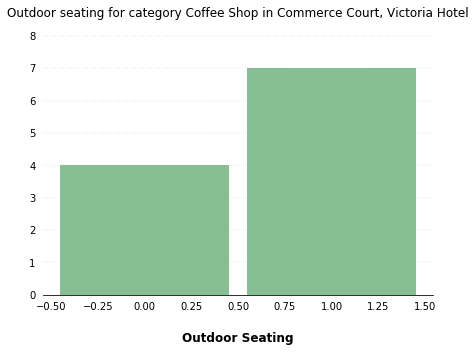

In [14]:
# Get the most common outdoor seating category
common_outdoor_seating = df_features.groupby("Outdoor Seating").count()['Name'].idxmax()
print("The most common outdoor seating category is {}".format(common_outdoor_seating))
binary_bins = [-0.5, 0.5, 1.5]
draw_histogram("Outdoor Seating", binary_bins, "Outdoor Seating", "Outdoor seating for category {} in {}".format(CATEGORY, NEIGHBOURHOOD))

The most common Wi-Fi category is 1


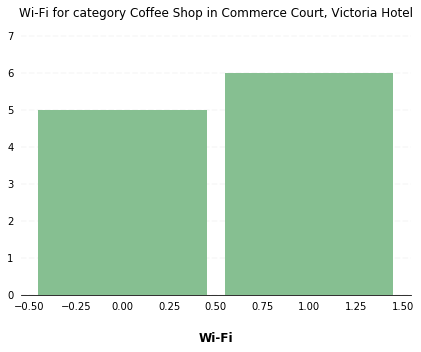

In [15]:
# Get the most common outdoor seating category
common_outdoor_seating = df_features.groupby("Wi-Fi").count()['Name'].idxmax()
print("The most common Wi-Fi category is {}".format(common_outdoor_seating))
binary_bins = [-0.5, 0.5, 1.5]
draw_histogram("Wi-Fi", binary_bins, "Wi-Fi", "Wi-Fi for category {} in {}".format(CATEGORY, NEIGHBOURHOOD))

In [16]:
# pull all the attribute analysis into a single place to be reused across multiple categories
def get_features_dataframe(neighbourhood, category):
    features = []
    for venue_id in get_ids_of_food_venues_with_category(neighbourhood, category):
        features.append(get_venue_features(venue_id))
    columns = get_value_features_column_names()
    
    return pd.DataFrame(data=features, columns=columns)

def calulate_common_price(df, neighbourhood, category):
    return df.groupby("Price").count()['Name'].idxmax(), None
    
def calculate_common_outdoor_setting(df, neighbourhood, category):
    common_setting = df.groupby("Outdoor Seating").count()['Name'].idxmax()

    num_of_common_setting = df.groupby("Outdoor Seating").count().loc[common_setting]["Name"]
    percentage = num_of_common_setting / len(df.index)
    
    return common_setting, percentage
    
def calculate_common_wifi(df, neighbourhood, category):
    common_setting = df.groupby("Wi-Fi").count()['Name'].idxmax()
    
    num_of_common_setting = df.groupby("Wi-Fi").count().loc[common_setting]["Name"]
    percentage = num_of_common_setting / len(df.index)

    return common_setting, percentage

def map_binary_option(value):
    mapping = {0:"No", 1:"Yes"}
    return mapping[value]
def process_df(df, neighbourhood, category):
    price, _dummy_val = calulate_common_price(df, neighbourhood, category)
    outdoor, outdoor_percentage = calculate_common_outdoor_setting(df, neighbourhood, category)
    wifi, wifi_percentage = calculate_common_wifi(df, neighbourhood, category)
    
    majority_threshold = 0.65
    outdoor_alt = 1 - outdoor
    wifi_alt = 1 - wifi
    out = []
    # first row is the baseline
    out.append([neighbourhood, category, price, map_binary_option(outdoor), map_binary_option(wifi), "Baseline"])
    # standard price, standard outdoor, alternative wifi
    if wifi_percentage > majority_threshold:
        out.append([neighbourhood, category, price, map_binary_option(outdoor), map_binary_option(wifi_alt), "Alternative"])
    # standard price, alt outdoor, standard wifi
    if outdoor_percentage > majority_threshold:
        out.append([neighbourhood, category, price, map_binary_option(outdoor_alt), map_binary_option(wifi), "Alternative"])
    if (price - 1) >= 1:
        # lower price, standard outdoor, standard wifi
        out.append([neighbourhood, category, price - 1, map_binary_option(outdoor), map_binary_option(wifi), "Alternative"])
    if (price + 1) <= 4:
        # higher price, standard outdoor, standard wifi
        out.append([neighbourhood, category, price + 1, map_binary_option(outdoor), map_binary_option(wifi), "Alternative"])
    
    columns = ["Neighbourhood", "Category", "Price", "Outdoor Seating", "Wifi", "Option"]
    
    return pd.DataFrame(data=out, columns=columns)
    
def analyse_category(neighbourhood, category):
    df = get_features_dataframe(neighbourhood, category)
    return process_df(df, neighbourhood, category)   

**Methodology**

In this project will focus on identifying unexploited niches in the food venues in the Toronto buroughs.

In the data section we identified the neighbourhoods with the highest density of food venues, and analysed one category.

The second step will be to do a similar analysis for the top three categories.

The third and final step will be to identify possible unexploited niches. These are categories where combinations of attributes are not present in the neighbourhood.

The analsis of the attributes of the venues in this report is necessarily limited because there is a low daily limit on the Foursquare API calls that provide the attribute information. With full access to the Foursquare API the unexploited niche analysis could be scaled up significantly.

In [19]:
# coffee shop category
df_coffee_shop = process_df(df_features, NEIGHBOURHOOD, CATEGORY)

In [26]:
# restaurant category
df_restaurant = analyse_category('Commerce Court, Victoria Hotel', 'Restaurant')

In [25]:
# fastfood category
df_fast_food = analyse_category('Commerce Court, Victoria Hotel', 'Fast Food Restaurant')

In [27]:
# combine the tables together
#df_neighbourhood = pd.concat([df_coffee_shop, df_restaurant, df_fast_food])


df_neighbourhood

**Results and Discussion**

Our analysis shows that there a few key neighbourhoods that have high densities of food venues. The neighbourhood with the highest density is Commerce Court, Victoria Hotel.

In that neighbourhood the three most common food venue types were:

-Coffee Shop

-Restaurant

-Fast Food Restaurant

For the restaurant category there was enough examples of with and without outdoor settings and wifi that it would not be a distinguishing feature, so the only alternative available in this neighbourhood is to vary the price point.

For the coffee shop category, there was few enough venues without outdoor seating to make it a potential feature as well.

In the case of the fastfood restaurant category, there is little experimentation with the outdoor seting and wifi features, meaning there are potentially underexploited niches available.

Analysing the three characteristics of price level, outdoor seating and wi-fi the following under exploited niches were idenfitied in the dataframe below.

The results are 6 options with the best probabilty of aligning with the existing foodtraffic and customer base in the area and with combination of features that allow the new venue to stand out.

In [23]:
options = [["Coffee Shop", 1, "No", "Yes", "Coffee anytime - even when it is raining"],
           ["Coffee Shop", 2, "Yes", "Yes", "Upmarket coffee and treats"],
           ["Restaurant", 1, "Yes", "No", "Cheap and cheerful dining experience"],
           ["Restaurant", 3, "Yes", "No", "Good meals, done well"],
           ["Fastfood Restaurant", 1, "Yes", "Yes", "Everything you expect AND wifi!"],
           ["Fastfood Restaurant", 1, "No", "No", "This place is about two things: food and fast"],
           ["Fastfood Restaurant", 2, "Yes", "No", "Fast food that is cut above the rest"]
          ]
 
columns = ["Category", "Price Tier", "Outdoor seating", "Wifi", "Nickname"]
df_options = pd.DataFrame(data=options, columns=columns)
df_options

,Category,Price Tier,Outdoor seating,Wifi,Nickname
0,Coffee Shop,1,No,Yes,Coffee anytime - even when it is raining
1,Coffee Shop,2,Yes,Yes,Upmarket coffee and treats
2,Restaurant,1,Yes,No,Cheap and cheerful dining experience
3,Restaurant,3,Yes,No,"Good meals, done well"
4,Fastfood Restaurant,1,Yes,Yes,Everything you expect AND wifi!
5,Fastfood Restaurant,1,No,No,This place is about two things: food and fast
6,Fastfood Restaurant,2,Yes,No,Fast food that is cut above the rest


**Conclusion**

The purpose of this project was to identify the neighbhourhoods with the highest density of food venues and identify a mix of features that would align with the existing customers in the neighbourhood and provide a basis for the new venue to stand out.

By calculating restaurant density from Foursquare data and a list of geographical locations for each postcode, when then use additional Foursquare data to determine key characteristics of each venue. From that we identified combinations of features that we not represented in the food venue population. These combinations of features are potentially under exploited business opportunities.

The final choice of which combination of features (if any) will be taken by the stakeholders guided by their experience, understanding of the market place and possibly additional analysis.